In [ ]:
'''
=====================================================
Lung Cancer Classification Project
=====================================================

 Steps for Random Forest (Classical ML)
=====================================================

1. Dataset Preparation
   - Load IQ-OTHNCCD dataset
   - Convert images to grayscale & resize (64x64 for efficiency)
   - Flatten each image into a 1D feature vector

2. Train-Test Split
   - Divide dataset into training and validation sets (80/20 split)

3. Train Random Forest Classifier
   - Use scikit-learn RandomForestClassifier
   - Fit on flattened image vectors

4. Prediction & Evaluation
   - Predict on validation set
   - Compute accuracy
   - Generate confusion matrix & classification report

5. Feature Importance (Optional)
   - Visualize most important features learned by Random Forest

'''


In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


In [15]:
# dataset paths
!pip install kagglehub

import kagglehub, os

# Download IQ-OTHNCCD Lung Cancer Dataset
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")
print("Dataset downloaded to:", path)

# Define dataset paths
DATA_DIR = os.path.join(path, "The IQ-OTHNCCD lung cancer dataset", "The IQ-OTHNCCD lung cancer dataset")
OUT_DIR = "data/processed_rf"
os.makedirs(OUT_DIR, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("OUT_DIR:", OUT_DIR)

label_map = {
    "Normal cases": 0,
    "Bengin cases": 1,
    "Malignant cases": 2
}

IMG_SIZE = 64   # smaller for speed (RandomForest works better with fewer features)


100%|████████████████████████████████████████| 199M/199M [01:51<00:00, 1.87MB/s]

Extracting files...


Dataset downloaded to: /Users/dhanushmanikanta/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2
DATA_DIR: /Users/dhanushmanikanta/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset
OUT_DIR: data/processed_rf


In [5]:
all_data = []
for cls, label in label_map.items():
    folder = os.path.join(DATA_DIR, cls)
    for fname in tqdm(os.listdir(folder), desc=cls):
        if fname.lower().endswith(".jpg"):
            path = os.path.join(folder, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img.astype(np.float32) / 255.0
            all_data.append([img.flatten(), label])  # flatten for RandomForest

df = pd.DataFrame(all_data, columns=["image","label"])
print("Dataset size:", len(df))


Malignant cases: 100%|███████████████████████| 561/561 [00:00<00:00, 561.30it/s]

Dataset size: 1097


In [7]:
from sklearn.model_selection import train_test_split

X = np.stack(df["image"].values)
y = df["label"].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (877, 4096) Val: (220, 4096)


In [9]:
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=20,           # tree depth (prevents overfitting)
    random_state=42,
    n_jobs=-1               # use all CPU cores
)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=42)

Validation Accuracy: 0.9545454545454546

Classification Report:
                  precision    recall  f1-score   support

   Normal cases       0.92      0.98      0.95        83
   Bengin cases       1.00      0.67      0.80        24
Malignant cases       0.97      1.00      0.99       113

       accuracy                           0.95       220
      macro avg       0.96      0.88      0.91       220
   weighted avg       0.96      0.95      0.95       220



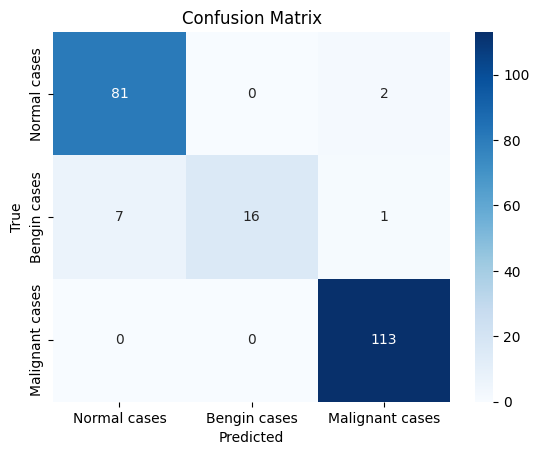

In [11]:
y_pred = rf.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred, target_names=list(label_map.keys())))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.keys()),
            yticklabels=list(label_map.keys()))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


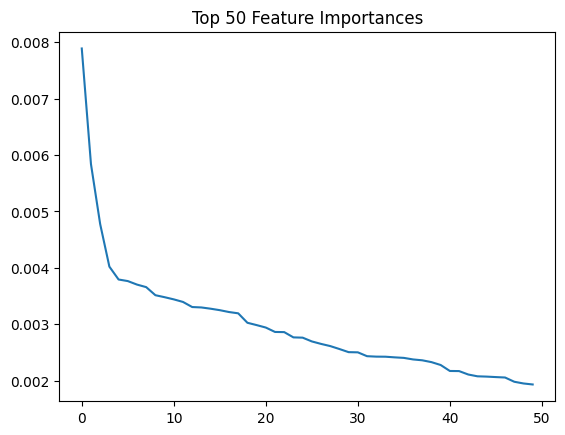

In [13]:
importances = rf.feature_importances_
plt.plot(sorted(importances, reverse=True)[:50])
plt.title("Top 50 Feature Importances")
plt.show()


In [ ]:
'''
=====================================================
🔹 Comparison of Models for Lung Cancer Classification
=====================================================

1. Random Forest (Classical ML)
-----------------------------------------------------
- Input: Flattened grayscale images (e.g., 64x64 → 4096 features)
- Feature Learning: No automatic feature learning → model sees raw pixel values
- Training Time: Fast (on CPU)
- Accuracy: Moderate (depends on image quality and preprocessing)
- Pros:
  * Simple and easy to train
  * Works well on small datasets
  * No need for GPU
- Cons:
  * Cannot capture spatial image patterns well
  * Limited accuracy compared to deep learning

2. Custom CNN (Deep Learning from Scratch)
-----------------------------------------------------
- Input: Grayscale images (e.g., 128x128)
- Feature Learning: Learns filters automatically (edges, textures, shapes)
- Training Time: Moderate (needs GPU for faster training)
- Accuracy: Better than Random Forest if dataset is large enough
- Pros:
  * Learns useful image features directly
  * End-to-end pipeline (raw image → classification)
  * Flexible and customizable
- Cons:
  * Needs more data than Random Forest
  * Risk of overfitting if dataset is small
  * Training is slower than Random Forest

3. ResNet (Transfer Learning with Pretrained Model)
-----------------------------------------------------
- Input: Resized images (128x128 or 224x224)
- Feature Learning: Uses pretrained convolutional layers (from ImageNet)
- Training Time: Longer per epoch, but fewer epochs needed
- Accuracy: Highest among the three (best generalization)
- Pros:
  * Pretrained weights → works even on small datasets
  * Residual connections → stable training for deep networks
  * Usually state-of-the-art accuracy
- Cons:
  * Requires GPU and more compute resources
  * Model size is larger (more parameters)

=====================================================
🔹 Summary
-----------------------------------------------------
- Random Forest → Fast, simple, good baseline
- Custom CNN   → Learns features from scratch, better than RF if enough data
- ResNet       → Most powerful, best accuracy, benefits from transfer learning
=====================================================
'''
